# Building and Evaluation model
in this notebook, we will build and evaluate a model.

In [1]:
# install modules
! pip install transformers
! pip install textaugment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 54.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 8.0 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-3.0.0-py3-none-any.whl size=

In [2]:
# mounting drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# import modules
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from textaugment import Wordnet
import random
import nltk
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModel
from tensorflow.keras.models import load_model
from sklearn.utils import resample
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

In [4]:
# read training data
data_train = pd.read_csv('/content/drive/MyDrive/sarcasm detection/ArSarcasm-v2/cleaned_sarcasam_train.csv')

data_train = data_train.drop(columns=['Unnamed: 0'])

data_train.head()

,sarcasm,sentiment,dialect,cleaned_tweet
0,False,POS,msa,اسماء شهداء ثور المجدللشهداء ريتوي تير جد قى
1,False,NEU,egypt,جبر إنس خير كفي عقل يحير لي نهارده يطلب شتهي ل...
2,False,NEG,egypt,ميس قليل دب مدرب حط خط دفاع ضرب تمرير حد
3,True,NEG,gulf,جنس مختلف جامع عرب شف شيء سيطر تام مسمى مك اشتراك
4,False,NEG,msa,ساويرس طالب منع مظاهر منتهى وقاح حد كبر لصوص ف...


In [5]:
# reading testing data
data_test = pd.read_csv('/content/drive/MyDrive/sarcasm detection/ArSarcasm-v2/cleaned_sarcasam_test.csv')

data_test = data_test.drop(columns=['Unnamed: 0'])

data_test.head()

,sarcasm,sentiment,dialect,cleaned_tweet
0,False,NEG,msa,خو حانق يالغل شف معصب عاد را شر فطر صبح قلاب م...
1,True,NEG,msa,اف مو متعود على ست
2,False,POS,msa,لهم شف مرض مرضى مسلم
3,False,POS,gulf,بشر طلق سات
4,True,NEG,msa,مؤشر خطير شخص برلمان كويت عرض لى ما شتم او است...


In [6]:
# convert labels to numerical
data_train['sarcasm'] = data_train['sarcasm'].astype(int)
data_test['sarcasm'] = data_test['sarcasm'].astype(int)

In [7]:
# count the number of values for each label
data_train['sarcasm'].value_counts()

0    10165
1     2157
Name: sarcasm, dtype: int64

In [8]:
# replace null values with space
data_train['cleaned_tweet'].fillna('', inplace=True)
data_test['cleaned_tweet'].fillna('', inplace=True)

In [9]:
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

## data augmentation
we will do data augmentation for sarcastic label because the dataset unbalanced.

In [10]:
# Initialize the Wordnet augmenter
aug = Wordnet()

def augment_text(text, num_aug=5):
    augmented_texts = []
    for _ in range(num_aug):
        augmented_text = aug.augment(text)
        augmented_texts.append(augmented_text)
    return augmented_texts

# Augment the positive class data
augmented_positive_texts = []
for text, label in zip(data_train['cleaned_tweet'], data_train['sarcasm']):
    if label == 1:
        augmented_texts = augment_text(text)
        augmented_positive_texts.extend(augmented_texts)

# Combine the augmented texts with the original data
augmented_data_train = data_train.append(
    [{'cleaned_tweet': text, 'sarcasm': 1} for text in augmented_positive_texts],
    ignore_index=True
)

<ipython-input-10-ad4def677fc1>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_data_train = data_train.append(


In [13]:
# Separate majority and minority classes
majority_class = augmented_data_train[augmented_data_train['sarcasm'] == 0]
minority_class = augmented_data_train[augmented_data_train['sarcasm'] == 1]

# Upsample minority class
minority_upsampled = resample(minority_class,
                               replace=True,  # sample with replacement
                               n_samples=len(majority_class),  # to match majority class
                               random_state=42)  # reproducible results

# Combine majority class with upsampled minority class
balanced_data_train = pd.concat([majority_class, minority_upsampled])

In [14]:
balanced_data_train['sarcasm'].value_counts()

0    10165
1    10165
Name: sarcasm, dtype: int64

## Building a model

In [4]:
# Load the tokenizer and model
model_name = "aubmindlab/bert-base-arabert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
arabert_model = TFAutoModel.from_pretrained(model_name)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
train_encodings = tokenizer(balanced_data_train['cleaned_tweet'].tolist(), padding=True, truncation=True, return_tensors="tf")
test_encodings = tokenizer(data_test['cleaned_tweet'].tolist(), padding=True, truncation=True, return_tensors="tf")

In [5]:
# Build the model architecture
input_layer = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name="input_ids")
arabert_output = arabert_model(input_layer).last_hidden_state

attention_layer = tf.keras.layers.Attention()([arabert_output, arabert_output])
attention_output = tf.keras.layers.GlobalAveragePooling1D()(attention_layer)

dropout_layer = tf.keras.layers.Dropout(0.5)(attention_output)
dense_layer = tf.keras.layers.Dense(64, activation="relu")(dropout_layer)
output_layer = tf.keras.layers.Dense(1, activation="sigmoid")(dense_layer)

model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# Define the optimizer and compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
# Calculate class weights for balanced data
total_samples = len(balanced_data_train)
class_weight = {0: total_samples / (2 * np.bincount(balanced_data_train['sarcasm'])[0]),
                1: total_samples / (2 * np.bincount(balanced_data_train['sarcasm'])[1])}

## fitting a model
we will take 10% from training dataset as validation dataset.

In [ ]:
# fitting
history = model.fit(
    train_encodings["input_ids"],
    balanced_data_train['sarcasm'],
    validation_split=0.1,
    epochs=10,
    batch_size=16,
    class_weight=class_weight,
    verbose=1
)


Epoch 1/10


1967/1967 [==============================] - 946s 455ms/step - loss: 0.4444 - accuracy: 0.7786 - val_loss: 0.1992 - val_accuracy: 0.9522
Epoch 2/10
1967/1967 [==============================] - 870s 442ms/step - loss: 0.1781 - accuracy: 0.9330 - val_loss: 0.0413 - val_accuracy: 0.9917
Epoch 3/10
1967/1967 [==============================] - 879s 447ms/step - loss: 0.0814 - accuracy: 0.9717 - val_loss: 0.0389 - val_accuracy: 0.9911
Epoch 4/10
1967/1967 [==============================] - 880s 447ms/step - loss: 0.0483 - accuracy: 0.9845 - val_loss: 0.0335 - val_accuracy: 0.9934
Epoch 5/10
1967/1967 [==============================] - 879s 447ms/step - loss: 0.0391 - accuracy: 0.9878 - val_loss: 0.0291 - val_accuracy: 0.9957
Epoch 6/10
1967/1967 [==============================] - 869s 442ms/step - loss: 0.0274 - accuracy: 0.9908 - val_loss: 0.0280 - val_accuracy: 0.9957
Epoch 7/10
1967/1967 [==============================] - 879s 447ms/step - loss: 0.0268 - accuracy: 0.9908 - val_loss: 0.034

## plotting
plot accuracy and loss for training and validation dataset.

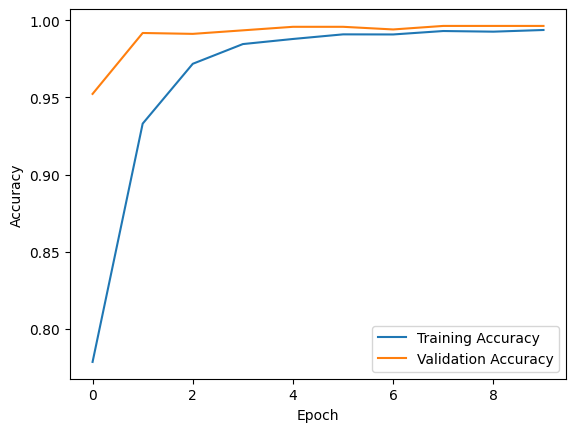

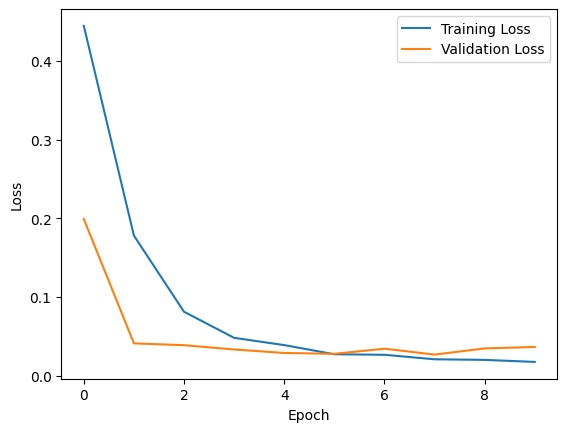

In [ ]:
# plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## saving and reload a model

In [ ]:
model.save('/content/drive/MyDrive/sarcasm detection/best model/sarcasm_BestModel.h5')

In [6]:
# Load the saved model weights
model.load_weights('/content/drive/MyDrive/sarcasm detection/best model/sarcasm_BestModel.h5')

# Display model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, None)]               0         []                            
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1351933   ['input_ids[0][0]']           
 )                           ngAndCrossAttentions(last_   44                                      
                             hidden_state=(None, None,                                            
                             768),                                                                
                              pooler_output=(None, 768)                                           
                             , past_key_values=None, hi                                       

## evaluate the model
we will use classification metrics for evaluate the model on testing dataset.


*   Precision
*   Recall
*   F1_Score



In [10]:
test_encodings = tokenizer(data_test['cleaned_tweet'].tolist(), padding=True, truncation=True, return_tensors="tf")
# Predictions for testing data
test_predictions = model.predict(test_encodings["input_ids"])
test_predictions = (test_predictions > 0.5).astype(int)

160/160 [==============================] - 43s 236ms/step


In [11]:
# Classification Report for testing data
print("Classification Report for Testing Data:")
print(classification_report(data_test['sarcasm'], test_predictions))

Classification Report for Testing Data:
              precision    recall  f1-score   support

           0       0.89      0.92      0.90      3944
           1       0.69      0.62      0.65      1166

    accuracy                           0.85      5110
   macro avg       0.79      0.77      0.78      5110
weighted avg       0.84      0.85      0.85      5110



In [13]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_encodings["input_ids"], data_test['sarcasm'])
print("Test Accuracy:", test_accuracy)

160/160 [==============================] - 48s 246ms/step - loss: 1.0919 - accuracy: 0.8497
Test Accuracy: 0.8497064709663391


In [14]:
precision = precision_score(data_test['sarcasm'], test_predictions)
recall = recall_score(data_test['sarcasm'], test_predictions)
f1 = f1_score(data_test['sarcasm'], test_predictions)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Precision: 0.6902485659655831
Recall: 0.6192109777015438
F1 Score: 0.6528028933092225
